### Training process

In [ ]:
#pip install matplotlib

In [1]:
import matplotlib.pyplot as plt 
from matplotlib import font_manager, lines
from IPython.core.display import HTML

font_dirs = ['../3rd_Run/font/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)  
    
# set font
plt.rcParams['font.family'] = "Arial" #  "Times New Roman"
plt.rcParams['font.size'] = 14
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
import os, datetime, pandas as pd, math
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator 
pd.set_option('display.max_rows', None)
newest_run = None
_timestamp = datetime.datetime.fromtimestamp(0)
tfevents_filename = None
for sub_dir in os.scandir('model/pretrain/runs/'):
    for file in os.scandir(sub_dir):
        if file.is_file():
            fname = file.name
            timestamp = datetime.datetime.fromtimestamp(int(fname.split('.')[3])) 
            print(f'Candidate: {fname}')
            if timestamp > _timestamp: 
                _timestamp = timestamp 
                tfevents_filename = file.path

print(f'Chosen: {tfevents_filename}')
ev_accu = EventAccumulator(tfevents_filename).Reload()  
df = pd.DataFrame({i: {ev.step: ev.value for ev in ev_accu.Scalars(i)} for i in ev_accu.Tags()['scalars'] })

df['flag'] = df.apply( lambda x: math.isclose(x['train/epoch'], round(x['train/epoch'], 0), abs_tol = 0.2), axis=1)
df = df[df['train/epoch'].notna()]
df['epoch'] = df.apply( lambda x: int(round(x['train/epoch'], 0)) , axis=1)
df['idx']   = df.index
df = df.drop_duplicates('epoch', keep='last')
df.tail(3)

Candidate: events.out.tfevents.1675393445.cm040.hpc.nyu.edu.2833992.0
Candidate: events.out.tfevents.1675406706.gr011.hpc.nyu.edu.263086.0
Candidate: events.out.tfevents.1675405671.cm040.hpc.nyu.edu.2854505.0
Chosen: model/pretrain/runs/Feb03_01-44-59_gr011.hpc.nyu.edu/events.out.tfevents.1675406706.gr011.hpc.nyu.edu.263086.0


,train/loss,train/learning_rate,train/epoch,eval/loss,eval/accuracy,eval/f1,eval/roc_auc,flag,epoch,idx
516000,0.0074,0.000211,578.479980,1.462288,0.830834,0.762542,0.891706,False,578,516000
516500,0.0064,0.000210,579.039978,1.451971,0.824807,0.761632,0.890434,True,579,516500
517500,0.0061,0.000210,580.159973,1.585162,0.831254,0.755979,0.888802,True,580,517500


In [3]:
df = df.rename(columns={'train/loss':'Loss', 'eval/accuracy':'Accuracy', 
                        'eval/f1':'F1-score', 'eval/roc_auc':'AUROC'})
df = df[['Loss', 'Accuracy', 'F1-score', 'AUROC','epoch','idx']]
df = df.set_index('epoch')
df.tail(3)

,Loss,Accuracy,F1-score,AUROC,idx
epoch,,,,,
578,0.0074,0.830834,0.762542,0.891706,516000
579,0.0064,0.824807,0.761632,0.890434,516500
580,0.0061,0.831254,0.755979,0.888802,517500


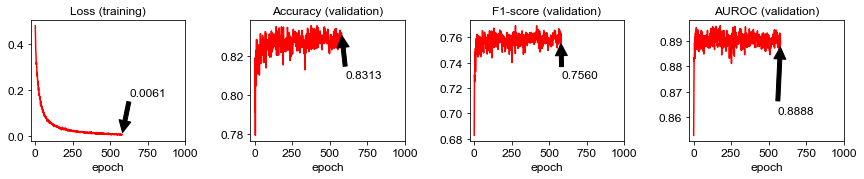

In [4]:
#fig, axs = plt.subplots(2, 2, figsize=(6.2, 5), constrained_layout=True) # (6.2, 8) (6.2, 14)
fig, axs = plt.subplots(1, 4, figsize=(12, 2.5), constrained_layout=True) # (6.2, 8) (6.2, 14)

fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0.0, wspace=0.1) 
xticks  = [0, 250, 500, 750, 1000] 
xytexts = [(0.15, 0.45), 
           (0.4, 0.55), 
           (0.65, 0.55), 
           (0.9, 0.35)]
titles  = ['Loss (training)','Accuracy (validation)','F1-score (validation)','AUROC (validation)'] 

for ax, col, xytext, title in zip(axs.flat, df.to_dict('dict').items(), xytexts, titles):
    x = list(col[1].keys()  )
    y = list(col[1].values())
    ax.plot(x, y, 'r', ls='-', ms=4)
    ax.set_title(title, fontdict={'fontsize': 12, 'fontweight': 'medium'}) 
    ax.set_xlabel('epoch', fontdict={'fontsize': 12, 'fontweight': 'medium'}) 
    ax.set_xticks(xticks, ) #  xlabels
    ax.annotate(f'{y[-1]:.4f}',
                xy=(x[-1], y[-1]),  # theta, radius
                xytext=xytext,    # fraction, fraction ax.get_position().y1
                textcoords='figure fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left',
                verticalalignment='bottom', fontsize=12
                )
    ax.tick_params(axis='both', which='major', labelsize=12) 
#fig.suptitle("Performance of the classifier on the validation set during the training", size=12)

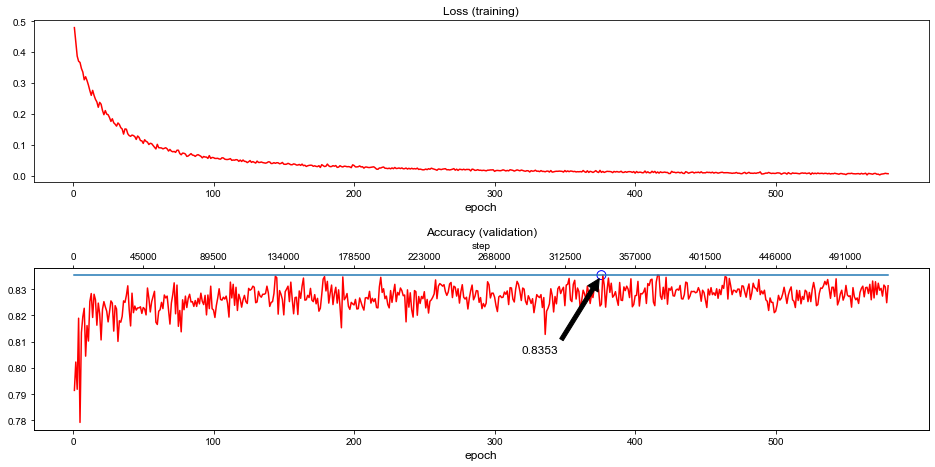

In [5]:
#fig, axs = plt.subplots(2, 2, figsize=(6.2, 5), constrained_layout=True) # (6.2, 8) (6.2, 14)
fig, axs = plt.subplots(2, 1, figsize=(13, 6.5), constrained_layout=True) # (6.2, 8) (6.2, 14)

fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0.0, wspace=0.1)  
xticks  = [i for i in range(0,max(df.index)+1,100)]
xytexts = [(0.15, 0.45), 
           (0.4, 0.55), 
           (0.65, 0.55), 
           (0.9, 0.35)]
titles  = ['Loss (training)','Accuracy (validation)','F1-score (validation)','AUROC (validation)'] 

tick_translate = lambda old: [df.loc[i, 'idx'] if i else 0 for i in old] 

for ax, col, xytext, title in zip(axs.flat, df.to_dict('dict').items(), xytexts, titles):
    if title not in ['Loss (training)', 'Accuracy (validation)'] : continue #
    x = list(col[1].keys()  )
    y = list(col[1].values())
    ax.plot(x, y, 'r', ls='-', ms=4)
    ax.set_title(title, fontdict={'fontsize': 12, 'fontweight': 'medium'}) 
    ax.set_xlabel('epoch', fontdict={'fontsize': 12, 'fontweight': 'medium'}) 
    ax.set_xticks(xticks, ) #  xlabels
    if title == 'Accuracy (validation)':
        ax2 = ax.twiny() 
        peak_x, peak_y = df['Accuracy'].argmax(), df['Accuracy'].max()  
        ax.add_line(lines.Line2D([df.index[0], df.index[-1]], [peak_y, peak_y]))
         
        ax2.set_xlim(ax.get_xlim())
        minor_xticks = [i for i in range(0,max(df.index)+1,50)]
        ax2.set_xticks(minor_xticks)
        ax2.set_xticklabels(tick_translate(minor_xticks))
        ax2.set_xlabel(r"step") 
        ax.scatter([peak_x], [peak_y], s=80, facecolors='none', edgecolors='b')  

        ax.annotate(f'{peak_y:.4f}',
                    xy=(peak_x, peak_y),  # theta, radius
                    xytext=(-80,-80),      # fraction, fraction ax.get_position().y1
                    textcoords='offset  points',
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    fontsize=12
                    )

    continue
    ax.annotate(f'{y[-1]:.4f}',
                xy=(x[-1], y[-1]),  # theta, radius
                xytext=xytext,    # fraction, fraction ax.get_position().y1
                textcoords='figure fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left',
                verticalalignment='bottom', fontsize=12
                )
    ax.tick_params(axis='both', which='major', labelsize=12) 
#fig.suptitle("Performance of the classifier on the validation set during the training", size=12)

### Confusion Matrix

In [ ]:
import pandas as pd, numpy as np, math
test_df = pd.read_csv('pred_1st.csv')
test_df.head(3)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay   

disp = ConfusionMatrixDisplay.from_predictions(
                      test_df.to_dict('list')['target'], 
                      test_df.to_dict('list')['prediction'], 
                      labels=[1,0],
                      cmap=plt.cm.Blues,
                      display_labels=['Good','Bad'], 
                      values_format='',   
) 
disp.figure_.set_figwidth(4)
disp.figure_.set_figheight(3)
#plt.title("Confusion Matrix")  
plt.savefig("confusionMatrix.png", dpi=300)

### P and R

In [ ]:
TP = sum([ 1 if i==1 and j==1 else 0 for i, j in zip(test_df['target'], test_df['prediction'])]) 
FP = sum([ 1 if i==0 and j==1 else 0 for i, j in zip(test_df['target'], test_df['prediction'])]) 
FN = sum([ 1 if i==1 and j==0 else 0 for i, j in zip(test_df['target'], test_df['prediction'])]) 
TN = sum([ 1 if i==0 and j==0 else 0 for i, j in zip(test_df['target'], test_df['prediction'])])  
 
Accuracy  = (TP + TN) / (TP + FP + FN + TN)
Precision = TP / ( TP + FP )
Recall    = TP / ( TP + FN )
F1        = TP / (TP + 0.5*(FP+FN)) 
MCC       = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) 

S = FN + FP + TP + TN
CEN =  (FN+FP)*math.log2(S*S-(TP-TN)*(TP-TN))/2/S-(FN*math.log2(FN)+FP*math.log2(FP))/S 

print(f'''{{ 
  "Accuracy":{Accuracy:.3f}, 
  "CEN":{CEN:.3f} 
  "F1":{F1:.3f} 
  "MCC":{MCC:.3f} 
  "Precision":{Precision:.3f} 
  "Recall":{Recall:.3f} 
}}
''')  

In [ ]:
TP = sum([ 1 if i==1 and j==1 else 0 for i, j in zip(test_df['target'], test_df['prediction'])]) 
FP = sum([ 1 if i==0 and j==1 else 0 for i, j in zip(test_df['target'], test_df['prediction'])]) 
FN = sum([ 1 if i==1 and j==0 else 0 for i, j in zip(test_df['target'], test_df['prediction'])]) 
TN = sum([ 1 if i==0 and j==0 else 0 for i, j in zip(test_df['target'], test_df['prediction'])])  
 
Accuracy  = (TP + TN) / (TP + FP + FN + TN)
Precision = TP / ( TP + FP )
Recall    = TP / ( TP + FN )
F1        = TP / (TP + 0.5*(FP+FN)) 
MCC       = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) 

S = FN + FP + TP + TN
CEN =  (FN+FP)*math.log2(S*S-(TP-TN)*(TP-TN))/2/S-(FN*math.log2(FN)+FP*math.log2(FP))/S 

print(f'''{{ 
  "Accuracy":{Accuracy:.3f}, 
  "CEN":{CEN:.3f} 
  "F1":{F1:.3f} 
  "MCC":{MCC:.3f} 
  "Precision":{Precision:.3f} 
  "Recall":{Recall:.3f} 
}}
''')  